In [1]:
!nvidia-smi

Thu Apr 26 18:27:01 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:26:00.0  On |                  N/A |
|  0%   46C    P8    14W / 200W |    689MiB /  8118MiB |     10%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# importing data science libraries
import pandas as pd

fraud_dataset = pd.read_csv('../data/nonames.csv')
print("There are ", len(fraud_dataset), " samples")
print(fraud_dataset.shape)
print(fraud_dataset.head(10))
print(fraud_dataset.describe())

There are  6362620  samples
(6362620, 12)
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64      170136.00       160296.36             0.0   
1     1   1864.28       21249.00        19384.72             0.0   
2     1    181.00         181.00            0.00             0.0   
3     1    181.00         181.00            0.00         21182.0   
4     1  11668.14       41554.00        29885.86             0.0   
5     1   7817.71       53860.00        46042.29             0.0   
6     1   7107.77      183195.00       176087.23             0.0   
7     1   7861.64      176087.23       168225.59             0.0   
8     1   4024.36        2671.00            0.00             0.0   
9     1   5337.77       41720.00        36382.23         41898.0   

   newbalanceDest  isFraud  CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0            0.00        0        0         0      0        1         0  
1            0.00        0        0         0      0        1

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
RANDOM_SEED = 42

In [5]:
X_train, X_test = train_test_split(fraud_dataset, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
# y_train = X_train["isFraud"].copy(deep=True)
X_train.pop("isFraud")
print("X_train: ", X_train.shape)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
y_test = X_test["isFraud"].copy(deep=True)
X_test.pop("isFraud")
print("X_test: ", X_test.shape)

X_train:  (5090096, 12)
X_train:  (5090096, 11)
X_train:  (4072076, 11)
X_val:  (1018020, 11)
X_test:  (1272524, 12)
X_test:  (1272524, 11)


In [6]:
input_shape = X_train.shape[1]

regulizer_value = 1e-5

hidden_layer = [10, 8, 4]
input_layer = Input(shape=(input_shape,))
encoder1 = Dense(hidden_layer[0], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(input_layer)
encoder2 = Dense(hidden_layer[1], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(encoder1)
encoder3 = Dense(hidden_layer[2], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(encoder2)
decoder1 = Dense(hidden_layer[2], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(encoder3)
decoder2 = Dense(hidden_layer[1], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(decoder1)
decoder3 = Dense(input_shape, activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(decoder2)
autoencoder = Model(inputs=input_layer, outputs=decoder3)

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 11)                99        
Total para

In [8]:
nb_epoch = 200
batch_size = 1000
# using mean squared error
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="../saved/basicAE4.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard])

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 1997016703469.3860 - acc: 0.4080 - val_loss: 1564392731422.9858 - val_acc: 0.5239
Epoch 2/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 1224612594740.9663 - acc: 0.5322 - val_loss: 479832136086.4938 - val_acc: 0.5492
Epoch 3/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 454038015615.8000 - acc: 0.5721 - val_loss: 453124138047.6316 - val_acc: 0.5817
Epoch 4/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 439584701817.8982 - acc: 0.5781 - val_loss: 452900923604.9435 - val_acc: 0.5852
Epoch 5/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 432867499042.5649 - acc: 0.5566 - val_loss: 471075146672.4755 - val_acc: 0.5567
Epoch 6/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 429150384579.4166 - acc: 0.5589 - val_l

4072076/4072076 [==============================] - 24s 6us/step - loss: 419997238485.4839 - acc: 0.8257 - val_loss: 429835080987.6766 - val_acc: 0.8262
Epoch 51/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 419996630821.3630 - acc: 0.8248 - val_loss: 440907779280.1154 - val_acc: 0.8899
Epoch 52/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 419043006120.9543 - acc: 0.8378 - val_loss: 459166541829.9146 - val_acc: 0.8172
Epoch 53/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 419857915161.8573 - acc: 0.8053 - val_loss: 431759257323.8876 - val_acc: 0.7410
Epoch 54/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 419219639423.1416 - acc: 0.8189 - val_loss: 431564528726.6058 - val_acc: 0.8364
Epoch 55/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 419299932151.3796 - acc: 0.8021 - val_loss: 430593839578.5916 - val_acc: 0.7635
Epoch 56/200
4072076/40

Epoch 100/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 418802793752.2398 - acc: 0.8584 - val_loss: 444358131751.4504 - val_acc: 0.8244
Epoch 101/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 418489563212.6336 - acc: 0.8566 - val_loss: 431965041500.5455 - val_acc: 0.8773
Epoch 102/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 418968121810.5330 - acc: 0.8723 - val_loss: 433056758498.9554 - val_acc: 0.9041
Epoch 103/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 418699416174.2062 - acc: 0.8639 - val_loss: 425417223088.5963 - val_acc: 0.8727
Epoch 104/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 418552485752.4241 - acc: 0.8577 - val_loss: 444363414207.0658 - val_acc: 0.9138
Epoch 105/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 418634879866.8472 - acc: 0.8602 - val_loss: 447188551570.9230 - val_acc: 0.8907
Epoc

4072076/4072076 [==============================] - 25s 6us/step - loss: 418224247787.0788 - acc: 0.8868 - val_loss: 455147650859.7807 - val_acc: 0.8793
Epoch 150/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 419079873566.0203 - acc: 0.8772 - val_loss: 436690697409.7917 - val_acc: 0.7902
Epoch 151/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 418523022110.7534 - acc: 0.8784 - val_loss: 434740149633.0285 - val_acc: 0.8312
Epoch 152/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 418766318905.1883 - acc: 0.8764 - val_loss: 433285524479.0545 - val_acc: 0.8618
Epoch 153/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 418441339329.7993 - acc: 0.8784 - val_loss: 425172382777.3751 - val_acc: 0.8793
Epoch 154/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 418696638786.1416 - acc: 0.8824 - val_loss: 456181505669.1274 - val_acc: 0.8838
Epoch 155/200
4072

4072076/4072076 [==============================] - 25s 6us/step - loss: 418301083173.6614 - acc: 0.9010 - val_loss: 428524599146.2455 - val_acc: 0.8826
Epoch 199/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 418764408151.8051 - acc: 0.8763 - val_loss: 424041186896.3995 - val_acc: 0.9260
Epoch 200/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 419395298059.4969 - acc: 0.8564 - val_loss: 427791507837.4879 - val_acc: 0.8678


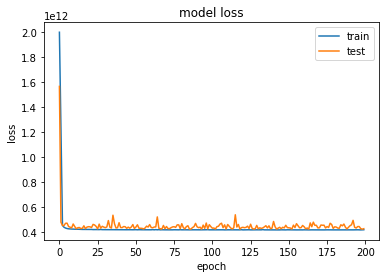

In [9]:
# importing visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

autoencoder = load_model('../saved/basicAE4.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [10]:
import numpy as np


predictions = autoencoder.predict(X_test)
# calculate my own MSE
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})
error_df.describe()
print(predictions.shape)

(1272524, 11)


In [11]:
print(predictions[0][:])
X_test.head(1)

[2.7707455e+02 3.0563088e+05 8.3101984e+04 3.1146762e+05 3.8665406e+05
 1.5763394e+05 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
3737323,278,330218.42,20866.0,351084.42,452419.57,122201.15,1,0,0,0,0
